In [127]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torch.functional as F
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import fastparquet
import re
from tqdm import tqdm
from IPython import display
import wandb

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [129]:
x_path = './GRU_data/combined_klek.parquet'
y_path = './GRU_data/combined_selfies.parquet'

In [130]:
# weights and biases
!wandb login

wandb: Currently logged in as: hubertrybka1 (mldd23). Use `wandb login --relogin` to force relogin


# Data prep

In [131]:
# alphabet of tokens for output

import selfies as sf
#data = pd.read_parquet(y_path)
data = pd.read_parquet(y_path)
alphabet = sf.get_alphabet_from_selfies(data.selfies)
alphabet.add("[start]")
alphabet.add("[end]")
alphabet.add("[nop]") # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))
#pad_to_len = max(sf.len_selfies(s) for s in data.selfies) + 10
pad_to_len = 128 # for simplicities' sake
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx2char = {i: s for i, s in enumerate(alphabet)}
print(alphabet)

['[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[/C]', '[/N]', '[/O]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N]', '[=O]', '[=Ring1]', '[=Ring2]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C@@H1]', '[C@@]', '[C@H1]', '[C@]', '[C]', '[Cl]', '[F]', '[I]', '[N+1]', '[NH1]', '[N]', '[O-1]', '[O]', '[P]', '[Ring1]', '[Ring2]', '[S]', '[\\C]', '[\\N]', '[\\O]', '[end]', '[nop]', '[start]']


In [132]:
class SELFIESVectorizer:
    def __init__(self, alphabet, pad_to_len=None):
        self.alphabet = alphabet
        self.char2idx = {s: i for i, s in enumerate(alphabet)}
        self.idx2char = {i: s for i, s in enumerate(alphabet)}
        self.pad_to_len = pad_to_len
    def vectorize(self, selfie, no_special=False):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        if no_special:
            splited = self.split_selfi(selfie)
        elif self.pad_to_len is None:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]']
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        X = np.zeros((len(splited), len(self.alphabet)))
        for i in range(len(splited)):
            X[i, self.char2idx[splited[i]]] = 1
        return X
    def devectorize(self, ohe, remove_special=False):
        ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
        selfie_str = ''
        for j in range(ohe.shape[0]):
            idx = np.argmax(ohe[j, :])
            if remove_special and (self.idx2char[idx] == '[start]' or self.idx2char[idx] == '[end]'):
                continue
            selfie_str += self.idx2char[idx]
        return selfie_str
    def idxize(self, selfie, no_special=False):
        if no_special:
            splited = self.split_selfi(selfie)
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        return np.array([self.char2idx[s] for s in splited])
    def deidxize(self, idx):
        return "".join([self.idx2char[i] for i in idx])
    def split_selfi(self, selfie):
        pattern = r'(\[[^\[\]]*\])'
        return re.findall(pattern, selfie)
vectorizer = SELFIESVectorizer(alphabet, pad_to_len)

In [133]:
from torch.utils.data import Dataset, DataLoader

class GRUDatasetv2(Dataset):
    def __init__(self, smiles_fp, selfies, vectorizer):
        self.smiles_fp = pd.read_parquet(smiles_fp)
        self.selfies = pd.read_parquet(selfies)
        self.selfies= self.prepare_y(self.selfies)
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.smiles_fp)
    def __getitem__(self, idx):
        raw_selfie = self.selfies[idx][0]
        vectorized_selfie = self.vectorizer.vectorize(raw_selfie)
        raw_X = self.smiles_fp.fps[idx]
        X = np.array(raw_X, dtype=int)
        X_reconstructed = self.reconstruct_fp(X)
        return torch.from_numpy(X_reconstructed).float(), torch.from_numpy(vectorized_selfie).float()

    @staticmethod
    def prepare_X(smiles_fp):
        fps = smiles_fp.fps.apply(eval).apply(lambda x: np.array(x, dtype=int))
        return fps
    @staticmethod
    def prepare_y(selfies):
        return selfies.values

    @staticmethod
    def reconstruct_fp(fp, length=4860):
        fp_rec = np.zeros(length)
        fp_rec[fp] = 1
        return fp_rec

In [134]:
dataset = GRUDatasetv2(x_path, y_path, vectorizer)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [135]:
print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Dataset size: 402863
Train size: 362576
Test size: 40287


In [136]:
batch_size = 256
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

# NN architecture

In [137]:
class EncoderNet(nn.Module):
    def __init__(self, fp_size, encoding_size):
        super(EncoderNet, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(fp_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, encoding_size)
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        #out.shape = [batch_size, 256]
        return out


class DecoderNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(DecoderNet, self).__init__()

        # GRU parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # output token count
        self.output_size = output_size

        # pytorch.nn
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                          dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=2)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        #x.shape = [batch_size, selfie_len, encoding_size] = [64, 128, 256]
        out, h = self.gru(x, h)
        #out.shape = [batch_size, selfie_len, hidden_size] = [64, 128, 256]
        #h.shape = [num_layers, batch_size, hidden_size] = [1, 64, 256]
        return out, h

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return h0

In [138]:
class EncoderDecoder(nn.Module):
    def __init__(self, fp_size=4860, encoding_size=256, hidden_size=256, num_layers=2, output_size=42, dropout=0.2):
        super(EncoderDecoder, self).__init__()
        self.encoder = EncoderNet(fp_size, encoding_size)
        self.decoder = DecoderNet(encoding_size, hidden_size, num_layers, output_size, dropout)
        self.encoding_size = encoding_size
        self.hidden_size = hidden_size

        #pytorch.nn
        self.fc = nn.Linear(hidden_size, 42)
        self.relu = nn.ReLU()
        self.softmax2d = nn.Softmax(dim=2)

    def forward(self, x):
        hidden = self.decoder.init_hidden(batch_size=x.shape[0]).to(device)
        encoded = self.encoder(x)
        x = encoded.unsqueeze(1)
        decoded = []
        for n in range(128):
            out, hidden = self.decoder(x, hidden)
            x = out
            out = self.relu(self.fc(out))
            decoded.append(out)
        out_cat = torch.cat(decoded, dim=1)
        out_cat = self.softmax2d(out_cat)
        return out_cat # shape [batch_size, selfie_len, alphabet_len]

# Training loop

In [139]:
class ConsciousCrossEntropy(nn.Module):
    def __init__(self):
        super(ConsciousCrossEntropy, self).__init__();
        self.batch_size = 256
        self.alphabet_len = 42
        self.seq_len = 128
        self.idx_ignore = 40 # index of token to ignore
        self.ignore = self.prep_token_to_ignore()

    def forward(self, target, predictions):
        cross_entropy_loss = 0
        for y_true, y in zip(target, predictions):
            sequence_loss = 0
            mask = self.prep_mask(y_true)
            nops = torch.sum(mask)
            product = torch.mul(y_true, y)
            prob = torch.sum(product, dim=1)
            loss = -torch.log(prob)
            loss_masked = torch.mul(loss, mask)
            sequence_loss = torch.sum(loss_masked)/(self.seq_len - nops)
            cross_entropy_loss += sequence_loss
        loss_value = cross_entropy_loss/self.batch_size
        return loss_value

    def prep_token_to_ignore(self):
        ignore = torch.zeros(self.alphabet_len).to(device)
        ignore[self.idx_ignore] = 1
        ignore = ignore.unsqueeze(0).repeat(128,1)
        return ignore

    def prep_mask(self, y_true):
        # look through target SELFIES sequence and prepare mask
        # as a tensor of size [128] with 0s on [nop] symbol
        # and 1s for all the other tokens
        v1 = torch.zeros(self.alphabet_len).to(device)
        v1[self.idx_ignore] = 1
        m1 = v1.unsqueeze(0).repeat(y_true.shape[0], 1)
        product = torch.mul(y_true, m1)
        output = ~torch.sum(product, dim=1).bool()
        output = output.float()
        return output

In [140]:
class ExamplePrinter():
    def __init__(self, test_loader, num_examples=10):
        self.dataloader = test_loader
        self.num_examples = num_examples

    def __call__ (self, model):
        model.eval()
        x, y = next(iter(self.dataloader))
        x = x.to(device)
        y = y.to(device)
        preds = self.model(x)
        preds_indices = torch.argmax(preds.cpu(), dim=2)
        preds_indices = decoded_indices.numpy()
        
        for molecule in preds_indices:
            vectorized = []
            #convert to one-hot
            for number in molecule:
                v = np.zeros(42)
                v[number] = 1
                vectorized.append(v)
            preds_OHE = np.array(vectorized)
        
        x_devectorized = devectorize_batch(x_OHE)
        y_devectorized = devectorize_batch(y)
        
        for j in range(num_examples):
            print(f'Predicted SELFIE:')
            print(x_devectorized[j])
            print(f'True SELFIE:')
            print(y_devectorized[j])
            print('-----------------------------------------')
        
    def devectorize_batch(self, batch):
        selfies_out = []
        for vectorized in batch:
            selfies_out.append(vectorizer.devectorize(vectorized, remove_special=True))
        return selfies_out

In [141]:
def train(train_loader, test_loader, device):

    # Set hyperparameters
    EPOCHS = 20
    encoding_size = 256
    hidden_size = 256
    num_layers = 1
    learn_rate = 0.001
    dropout = 0 # dropout must be equal 0 if num_layers = 1

    # Define dataframe for training progess display
    epochs_range = range(1,EPOCHS+1)
    metrics = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss']);
    metrics['epoch'] = epochs_range
    
    # Initialize example printer
    printer = ExamplePrinter(test_loader, num_examples=10)

    # Define pyplot for plotting metrics
    fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
    dh = display.display(fig, display_id=True)

    # Instantiating the model
    model = EncoderDecoder(
        fp_size=4860,
        encoding_size=encoding_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout).to(device)

    # Defining loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    criterion = ConsciousCrossEntropy()

    # wandb config and init
    config = dict()
    config['learning rate'] = learn_rate
    config['encoding size'] = model.encoding_size
    config['criterion'] = criterion
    config['optimizer'] = optimizer
    config['num epochs'] = EPOCHS
    config['Trainable parameters'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    config['hidden size'] = model.hidden_size
    config['Number of layers'] = num_layers
    config['Dropout'] = model.decoder.dropout
    config['Batch size'] = batch_size
    wandb.init(project="encoded-to-GRU-input", config=config)

    model.train()
    print("Starting Training of GRU")
    print(f"Device: {device}")
    # Start training loop
    for epoch in epochs_range:
        print(f'Epoch: {epoch}')
        epoch_loss = 0

        for batch_idx, (X,y) in enumerate(tqdm(train_loader)):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X).to(device)
            loss = criterion(y, output)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # calculate loss and log to wandb

        avg_loss = epoch_loss / len(train_loader)
        val_loss = evaluate(model, test_loader)
        metrics_dict = {'epoch': epoch,
                        'train_loss': avg_loss,
                        'val_loss': val_loss}
        wandb.log(metrics_dict)

        model.train()
        # Update metrics df
        metrics.loc[len(metrics)] = metrics_dict

        # Display metrics
        ax[0].clear()
        ax[0].plot(metrics.epoch, metrics.train_loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('CrossEntropy')
        ax[1].clear()
        ax[1].plot(metrics.epoch, metrics.val_loss)
        ax[1].set_title('validation loss')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('CrossEntropy')
        dh.update(fig)
        
        printer(model)
        
    plt.close()
    wandb.finish()
    return model

def evaluate(model, test_loader):
    model.eval()
    criterion = ConsciousCrossEntropy()
    epoch_loss = 0
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X).to(device)
        loss = criterion(y, output)
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(test_loader)
    return avg_loss

# Init and train the model

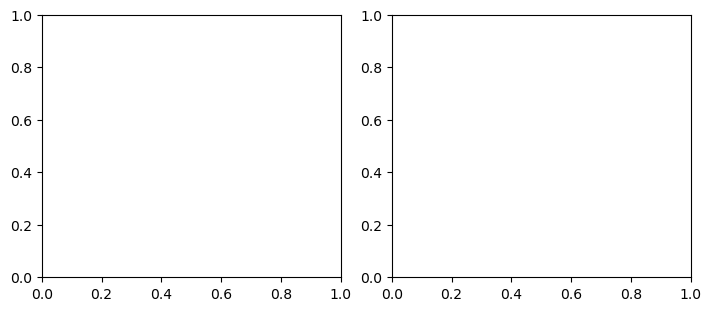

wandb: Currently logged in as: hubertrybka1 (mldd23). Use `wandb login --relogin` to force relogin


Starting Training of GRU
Device: cuda
Epoch: 1


  3%|█▎                                       | 47/1416 [00:17<09:12,  2.48it/s]

In [ ]:
model = train(train_loader, test_loader, device)

In [49]:
# save model just in case
torch.save(model.state_dict(), './GRU_data/')

In [110]:
model = EncoderDecoder(num_layers=1, output_size=42, dropout=0).to(device)
model.load_state_dict(torch.load('./GRU_data/SGD_lr0_0005.pt'))

<All keys matched successfully>

In [111]:
x, y = next(iter(test_loader))
x = x.to(device)
x.size()

torch.Size([256, 4860])

In [112]:
decoded = model(x)

# GRU output to SELFIES

In [113]:
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()

y_indices = torch.argmax(y, dim=2)
y_indices = y_indices.numpy()

In [114]:
def devectorize_batch(batch):
    selfies_out = []
    for i in batch:
        vectorized = []
        #convert to one-hot
        for number in i:
            v = np.zeros(42)
            v[number] = 1
            vectorized.append(v)
        vectorized = np.array(vectorized)
        selfies_out.append(vectorizer.devectorize(vectorized, remove_special=True))
        #print(f'Original: {vectorizer.devectorize(original.cpu().numpy())} \n')
        #print(f'Decoded:  {vectorizer.devectorize(vectorized)}')
        #print('------------------')
    return selfies_out

pred_devectorized = devectorize_batch(decoded_indices)
y_devectorized = devectorize_batch(y_indices)

In [115]:
def batch_selfies_to_smiles(selfies_batch):
    smiles = []
    for selfie in selfies_batch:
        smile = sf.decoder(selfie, attribute=False)
        smiles.append(smile)
    return smiles

smiles_pred = batch_selfies_to_smiles(pred_devectorized)
smiles_y = batch_selfies_to_smiles(y_devectorized)
smiles_pred = np.array(smiles_pred)
smiles_y = np.array(smiles_y)
pairs = np.stack([smiles_y, smiles_pred]).T

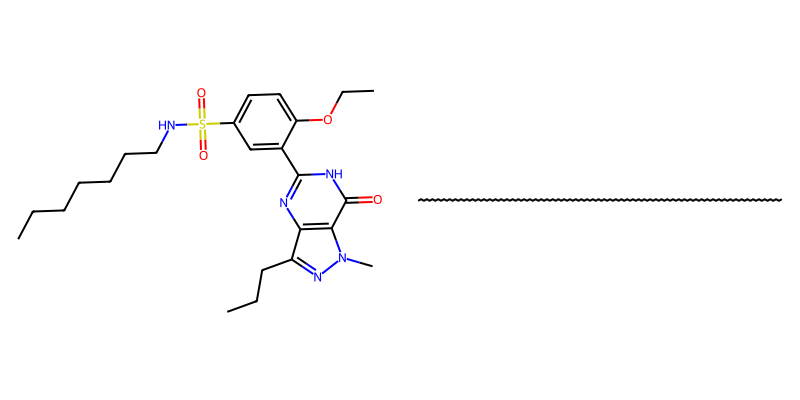

In [119]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

ori, pred = pairs[56]
pred = rdkit.Chem.MolFromSmiles(pred)
ori = rdkit.Chem.MolFromSmiles(ori)
rdkit.Chem.Draw.MolsToImage([ori, pred], molsPerRow=2, subImgSize=(400, 400))

In [108]:
pred_devectorized[23]

'[C][C][N][C][=Branch1][C][=O][C][=C][Ring1][C][C][C][=C][C][=C][C][=C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1]'